In [1]:
import numpy as np
import scipy as sp
import pandas as pd # load data
import matplotlib.pyplot as plt # plotting

In [2]:
from Module_241021 import (load_data_w_glob,
                           plot_distributions_at_diff_scale_factors
                          )

In [3]:
# load time diff data
diff_tau_all = pd.read_csv("time_delay_diff_241021.csv")

# load + pickout velocity data
PSA_all_df = load_data_w_glob(directory_path="PSA_data", file_pattern="*241021.csv")
velocity_all = PSA_all_df[["network", "parameter", "rel change", "condition 1", "condition 2", "velocity"]]

In [4]:
velocity_all

,network,parameter,rel change,condition 1,condition 2,velocity
0,GNEO1,KOG,1.00,True,True,0.529175
1,GNEO1,KOG,1.00,True,True,0.529036
2,GNEO1,KOG,1.00,True,True,0.514470
3,GNEO1,KOG,1.00,True,True,0.513546
4,GNEO1,KOG,1.00,True,True,0.515932
...,...,...,...,...,...,...
450795,GN,KaaNG,0.75,True,True,0.305627
450796,GN,KaaNG,0.75,True,True,0.305407
450797,GN,KaaNG,0.75,True,True,0.305059
450798,GN,KaaNG,0.75,True,True,0.311995


## A closer look at delay time differences between the GN and GNE networks

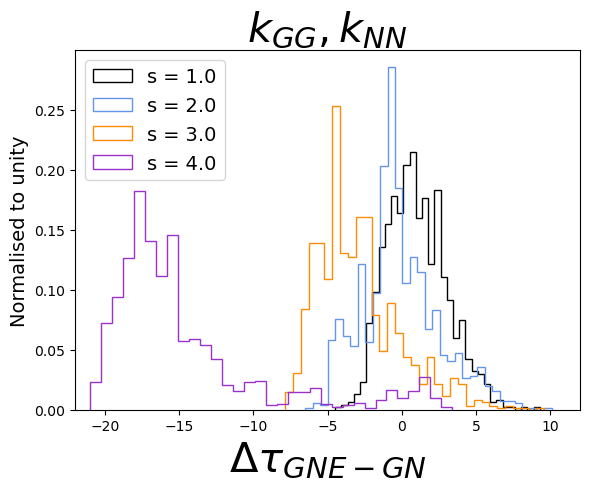

In [5]:
plot_distributions_at_diff_scale_factors(dataframe=diff_tau_all,network="GNEvGN", parameter="KaaNG",
                                         scalefactor_array=[2.0, 3.0, 4.0],
                                         title=r"$k_{GG}, k_{NN}$", x_label=r"$\Delta\tau_{GNE-GN}$",
                                         xmin=-22, xmax=12,
                                         date="241105", datatype="time diff",
                                         legend_loc="upper left",savefig=True)

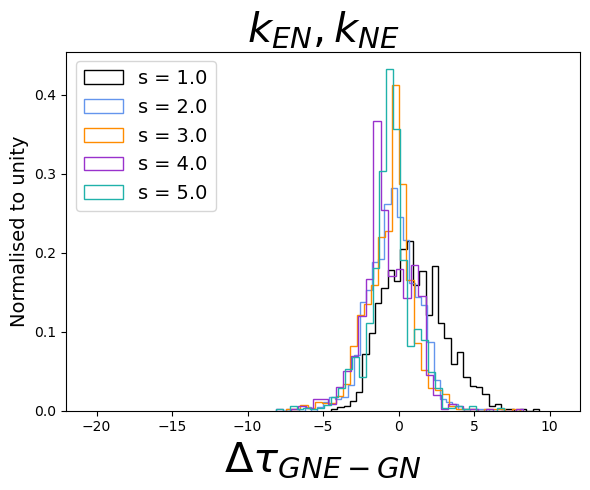

In [6]:
plot_distributions_at_diff_scale_factors(dataframe=diff_tau_all,network="GNEvGN", parameter="KmiEN",
                                         scalefactor_array=[2.0, 3.0, 4.0, 5.0],
                                         title=r"$k_{EN}, k_{NE}$", x_label=r"$\Delta\tau_{GNE-GN}$",
                                         xmin=-22, xmax=12,
                                         date="241105",
                                         datatype="time diff",legend_loc="upper left",
                                         savefig=True)

### Fit distributions to a double gaussian (bi-modality) and a skewed distribution (single peak).

Motivation:
In Knudsen et al, bi-modility is observed for time delay differences. I want to investigate if the case applies here too. This is done by fitting the distributions to a double-gaussian and a model with only one peak.

If bi-modal, does the negative delay time differences arise from higher occurances of negative delay time differences (higher peak) or does the delay time differences become more negative (broader distance between peaks)?


**Fit functions:** <br>

Inverse Guassian Distribution: <br>

$f(x;\mu ,\lambda )={\sqrt {\frac {\lambda }{2\pi x^{3}}}}\exp {\biggl (}-{\frac {\lambda (x-\mu )^{2}}{2\mu ^{2}x}}{\biggr )}$


Double Gaussian: <br>

$g(x)=A_1 \exp \left(-{\frac {1}{2}}{\frac {(x-\mu_1 )^{2}}{\sigma_1 ^{2}}}\right) + A_2 \exp \left(-{\frac {1}{2}}{\frac {(x-\mu_2 )^{2}}{\sigma_2 ^{2}}}\right).$

In [177]:
from iminuit import Minuit
from scipy import stats
import os, sys 
sys.path.append('/Users/siljaxianpallisgaardsvendsen/Documents/KU_K/8_AppStat/AppStat2023')
from ExternalFunctionsNew import Chi2Regression, BinnedLH, UnbinnedLH

In [158]:
# load data
dataframe=diff_tau_all
mask0 = dataframe["two_networks"]=="GNEvGN"
mask1 = dataframe["parameter"]=="KaaNG"
mask2 = dataframe["rel change"]==2.0

sample = dataframe[mask0 & mask1 & mask2]["time diff"]

Nbins = int(np.sqrt(len(sample)))
binwidth = (max(sample)-min(sample))/float(Nbins)
print("bindwidth", binwidth)

bindwidth 0.5031457323247661


In [206]:
def fit_skewed_gaussian(x, N1,mu, sigma, alpha):
    phi = np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    Phi = norm.cdf(alpha * (x - mu) / sigma)
    return N1*2 * phi * Phi

def fit_double_gaussian_pol0(x, N1, N2, mu1, mu2, sigma1, sigma2, const):
    norm1 = binwidth * N1/ np.sqrt(2.0*np.pi) / sigma1
    norm2 = binwidth * N2/ np.sqrt(2.0*np.pi) / sigma2
    z1 = (x-mu1)/sigma1
    z2 = (x-mu2)/sigma2
    return norm1 * np.exp(-0.5*z1*z1) + norm2 * np.exp(-0.5*z2*z2) + const


def fit_skewed_double_gaussian(x, N1, N2, mu1, mu2, sigma1, sigma2, alpha1, alpha2):
    # Skewed Gaussian component 1
    phi1 = np.exp(-0.5 * ((x - mu1) / sigma1) ** 2) / (sigma1 * np.sqrt(2 * np.pi))
    Phi1 = norm.cdf(alpha1 * (x - mu1) / sigma1)
    skewed_gaussian1 = N1 * 2 * phi1 * Phi1
    
    # Skewed Gaussian component 2
    phi2 = np.exp(-0.5 * ((x - mu2) / sigma2) ** 2) / (sigma2 * np.sqrt(2 * np.pi))
    Phi2 = norm.cdf(alpha2 * (x - mu2) / sigma2)
    skewed_gaussian2 = N2 * 2 * phi2 * Phi2

    return skewed_gaussian1 + skewed_gaussian2

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 131                        │              Nfcn = 238              │
│ EDM = 7.4e-05 (Goal: 0.0002)     │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

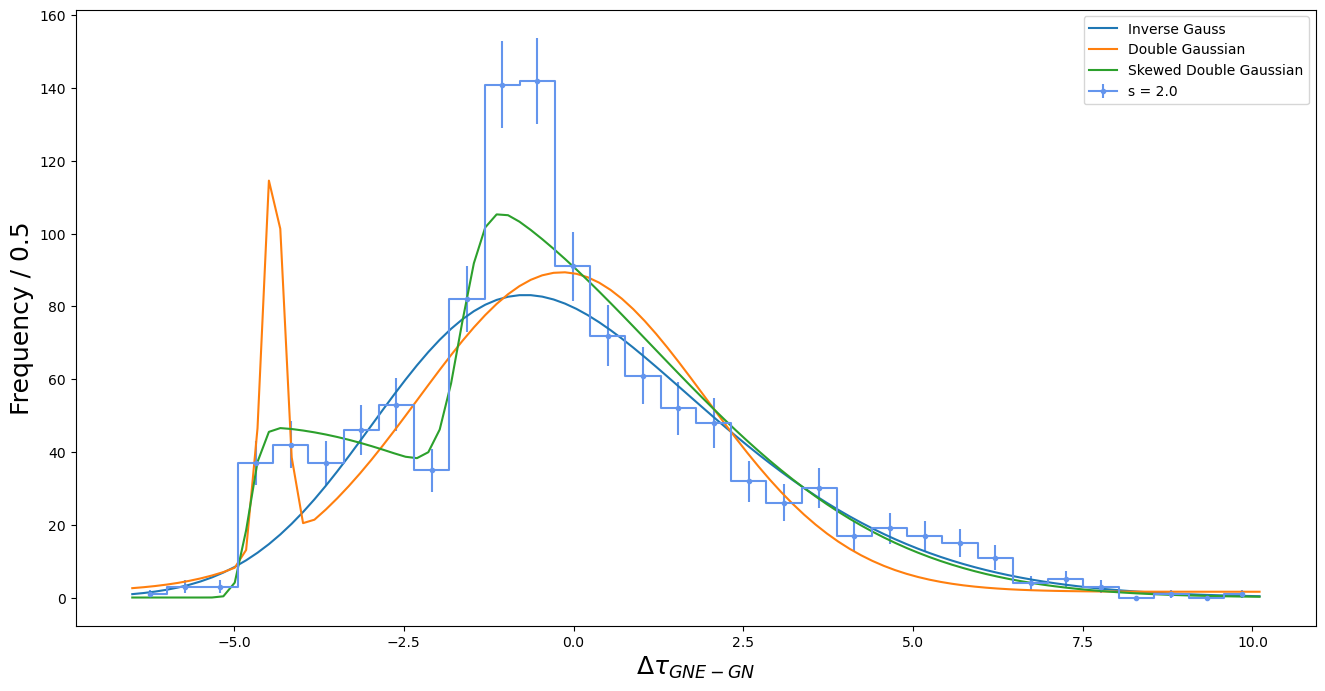

In [209]:
# 0. Prepare data for fitting
binning = np.linspace(min(sample),max(sample),Nbins)
counts, bin_edges = np.histogram(sample,bins=binning)
unc_count = np.sqrt(counts)
X = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2.
select = counts>0                                          # only bins with non-zero entries.

# 1.1 chi2 fitting: fit inverse gaussian
chi2reg_skewness= Chi2Regression(fit_skewed_gaussian, X[select], counts[select], unc_count[select])
minuit_obj_skewness = Minuit(chi2reg_skewness,
                             N1=250,mu=0, sigma=1, alpha=1) # initial fit params guess
minuit_obj_skewness.errordef = 1.0                         # chi2 fit
print(minuit_obj_skewness.migrad())

# 1.2 chi2 fitting: fit double gaussian with background
chi2reg_doublegauss = Chi2Regression(fit_double_gaussian_pol0, X[select], counts[select], unc_count[select])
minuit_obj_doublegauss = Minuit(chi2reg_doublegauss,
                    N1=80, N2=924, mu1=-4.4, mu2=-0.2,
                    sigma1=0.15, sigma2=2.11, const=1.6)   # initial fit params guess
minuit_obj_doublegauss.errordef = 1.0                      # chi2 fit
print(minuit_obj_doublegauss.migrad())



chi2reg_sdoublegauss = Chi2Regression(fit_skewed_double_gaussian, X[select], counts[select], unc_count[select])
minuit_obj_sdoublegauss = Minuit(chi2reg_sdoublegauss,
                     N1=50, N2=100, mu1=-4, mu2=0, sigma1=1,
                                sigma2=1, alpha1=0, alpha2=0) # initial fit params guess
minuit_obj_sdoublegauss.errordef = 1.0                      # chi2 fit
print(minuit_obj_sdoublegauss.migrad())

# 2. plotting
fig, ax = plt.subplots(figsize=(16, 8))

# 2.1 data
ax.errorbar(X, counts, yerr=unc_count, marker = '.', drawstyle = 'steps-mid',
            color="cornflowerblue", label="s = 2.0")
ax.set_xlabel(r'$\Delta\tau_{GNE-GN}$', fontsize=18)
ax.set_ylabel(f"Frequency / {np.around(binwidth,2)}", fontsize=18);



# 2.2 fit functions
x = np.linspace(min(sample), max(sample), 100)
ax.plot(x, fit_skewed_gaussian(x, *minuit_obj_skewness.values[:]), label="Inverse Gauss")
ax.plot(x, fit_double_gaussian_pol0(x, *minuit_obj_doublegauss.values[:]), label="Double Gaussian")
ax.plot(x, fit_skewed_double_gaussian(x, *minuit_obj_sdoublegauss.values[:]), label="Skewed Double Gaussian")

# fit functions
plt.legend()

In [ ]:
chi2_obj_better_value = minuit_obj_better.fval 
Ndof_obj_better_value = len(X[select]) - minuit_obj_better.nfit
Prob_obj_better_value = stats.chi2.sf(chi2_obj_better_value, Ndof_obj_better_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_obj_better_value:.1f} Ndof = {Ndof_obj_better_value:.0f} Prob(Chi2,Ndof) = {Prob_obj_better_value}")
